This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 00:14:22--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.50.72, 54.231.136.160, 52.217.199.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.50.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.7MB/s    in 0.6s    

2023-11-05 00:14:23 (20.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

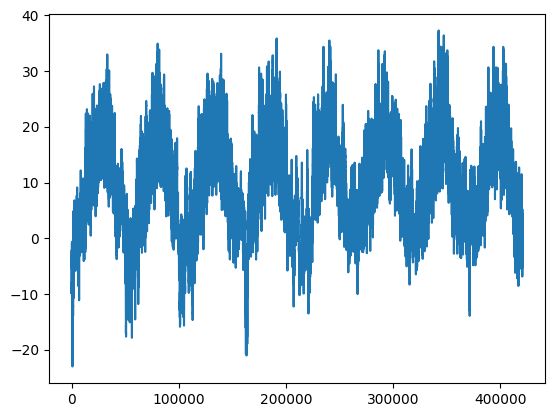

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

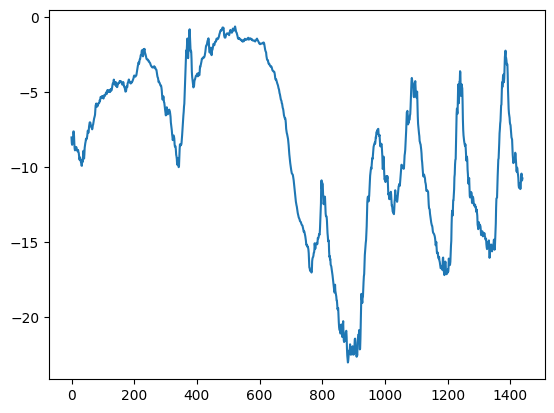

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 49s 59ms/step - loss: 13.6923 - mae: 2.8338 - val_loss: 10.9931 - val_mae: 2.6187
Epoch 2/5
819/819 [==============================] - 50s 61ms/step - loss: 9.0571 - mae: 2.3659 - val_loss: 11.1750 - val_mae: 2.6428
Epoch 3/5
819/819 [==============================] - 44s 54ms/step - loss: 8.2795 - mae: 2.2639 - val_loss: 11.2911 - val_mae: 2.6637
Epoch 4/5
819/819 [==============================] - 44s 53ms/step - loss: 7.8222 - mae: 2.2024 - val_loss: 11.7998 - val_mae: 2.7148
Epoch 5/5
405/405 [==============================] - 14s 34ms/step - loss: 11.8320 - mae: 2.7104
Test MAE: 2.71


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 57s 67ms/step - loss: 12.4288 - mae: 2.7285 - val_loss: 10.1191 - val_mae: 2.5180
Epoch 2/5
819/819 [==============================] - 55s 67ms/step - loss: 8.4281 - mae: 2.2795 - val_loss: 10.7281 - val_mae: 2.5784
Epoch 3/5
819/819 [==============================] - 57s 69ms/step - loss: 7.3128 - mae: 2.1249 - val_loss: 10.7909 - val_mae: 2.5856
Epoch 4/5
819/819 [==============================] - 56s 68ms/step - loss: 6.6427 - mae: 2.0262 - val_loss: 11.7897 - val_mae: 2.7099
Epoch 5/5
405/405 [==============================] - 17s 41ms/step - loss: 11.4702 - mae: 2.6691
Test MAE: 2.67


**Plotting results**

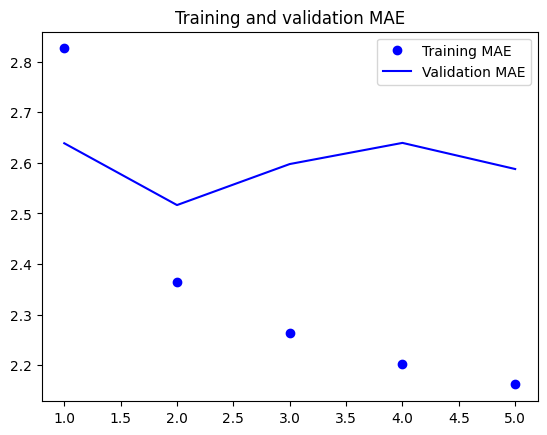

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 75s 91ms/step - loss: 20.3026 - mae: 3.5348 - val_loss: 15.3929 - val_mae: 3.1220
Epoch 2/5
819/819 [==============================] - 71s 86ms/step - loss: 14.6995 - mae: 3.0518 - val_loss: 15.8704 - val_mae: 3.1254
Epoch 3/5
819/819 [==============================] - 76s 93ms/step - loss: 13.6221 - mae: 2.9338 - val_loss: 14.3177 - val_mae: 2.9814
Epoch 4/5
819/819 [==============================] - 74s 90ms/step - loss: 12.8692 - mae: 2.8468 - val_loss: 15.2657 - val_mae: 3.0738
Epoch 5/5
405/405 [==============================] - 18s 44ms/step - loss: 15.6535 - mae: 3.1275
Test MAE: 3.13


### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 125s 149ms/step - loss: 42.8105 - mae: 4.7626 - val_loss: 12.4520 - val_mae: 2.6776
Epoch 2/5
819/819 [==============================] - 130s 159ms/step - loss: 10.9635 - mae: 2.5673 - val_loss: 9.8589 - val_mae: 2.4555
Epoch 3/5
819/819 [==============================] - 130s 158ms/step - loss: 9.6807 - mae: 2.4152 - val_loss: 9.8189 - val_mae: 2.4517
Epoch 4/5
819/819 [==============================] - 104s 126ms/step - loss: 9.1268 - mae: 2.3408 - val_loss: 9.7255 - val_mae: 2.4434
Epoch 5/5
405/405 [==============================] - 24s 58ms/step - loss: 10.8068 - mae: 2.5757
Test MAE: 2.58


## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 153s 183ms/step - loss: 50.2172 - mae: 5.2807 - val_loss: 13.9217 - val_mae: 2.8124
Epoch 2/5
819/819 [==============================] - 152s 185ms/step - loss: 20.0154 - mae: 3.4355 - val_loss: 10.0644 - val_mae: 2.4640
Epoch 3/5
819/819 [==============================] - 170s 207ms/step - loss: 18.3592 - mae: 3.2938 - val_loss: 9.7852 - val_mae: 2.4343
Epoch 4/5
819/819 [==============================] - 166s 203ms/step - loss: 17.4677 - mae: 3.2162 - val_loss: 9.4411 - val_mae: 2.4012
Epoch 5/5
405/405 [==============================] - 22s 54ms/step - loss: 10.8785 - mae: 2.5854
Test MAE: 2.59


 **Plotting results of dropout-regularized LSTM**

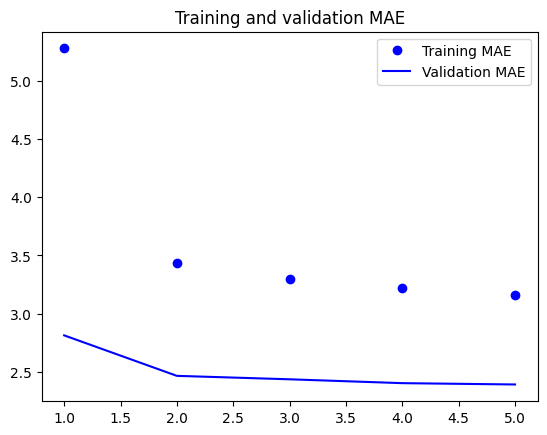

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model- Not needed**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 319s 382ms/step - loss: 24.2522 - mae: 3.6498 - val_loss: 9.6963 - val_mae: 2.4106
Epoch 2/5
819/819 [==============================] - 311s 378ms/step - loss: 14.0202 - mae: 2.9028 - val_loss: 9.4795 - val_mae: 2.3985
Epoch 3/5
819/819 [==============================] - 306s 373ms/step - loss: 13.3090 - mae: 2.8286 - val_loss: 8.8427 - val_mae: 2.3018
Epoch 4/5
819/819 [==============================] - 309s 377ms/step - loss: 12.7132 - mae: 2.7628 - val_loss: 9.5603 - val_mae: 2.4172
Epoch 5/5
405/405 [==============================] - 39s 95ms/step - loss: 9.8051 - mae: 2.4442
Test MAE: 2.44


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 154s 184ms/step - loss: 27.1519 - mae: 3.7456 - val_loss: 10.6941 - val_mae: 2.5326
Epoch 2/5
819/819 [==============================] - 133s 162ms/step - loss: 9.4705 - mae: 2.3955 - val_loss: 10.0385 - val_mae: 2.4593
Epoch 3/5
819/819 [==============================] - 138s 168ms/step - loss: 8.6404 - mae: 2.2852 - val_loss: 10.2292 - val_mae: 2.4780
Epoch 4/5
819/819 [==============================] - 150s 183ms/step - loss: 8.1664 - mae: 2.2230 - val_loss: 10.4470 - val_mae: 2.5037
Epoch 5/5
405/405 [==============================] - 29s 70ms/step - loss: 10.9463 - mae: 2.5967
Test MAE: 2.60


In [ ]:
### Combination of 1D Convent and dropout-regularized LSTM

In [18]:
combined = layers.concatenate([conv_x, lstm_x])
outputs = layers.Dense(1)(combined)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 150s 179ms/step - loss: 16.2673 - mae: 3.1114 - val_loss: 9.2653 - val_mae: 2.3751
Epoch 2/5
819/819 [==============================] - 169s 206ms/step - loss: 15.9026 - mae: 3.0747 - val_loss: 9.2797 - val_mae: 2.3750
Epoch 3/5
819/819 [==============================] - 167s 204ms/step - loss: 15.4785 - mae: 3.0344 - val_loss: 9.2611 - val_mae: 2.3652
Epoch 4/5
819/819 [==============================] - 157s 191ms/step - loss: 15.2243 - mae: 3.0091 - val_loss: 9.1071 - val_mae: 2.3461
Epoch 5/5
405/405 [==============================] - 23s 57ms/step - loss: 10.5596 - mae: 2.5653
Test MAE: 2.57


**Plotting results of the combination**

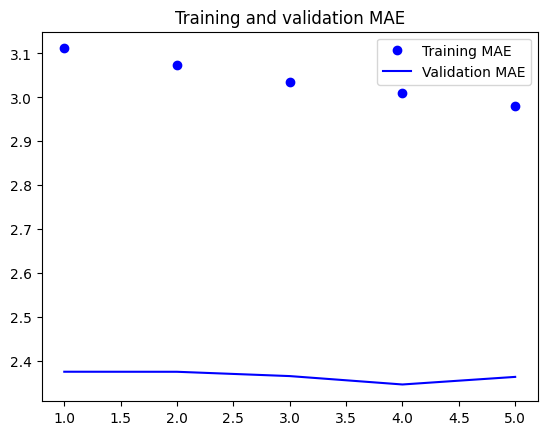

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()